In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# 加载数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [2]:
# 零均值归一化
def normalize(X_train, X_test):
    X_train = X_train / 255.
    X_test = X_test / 255.

    mean = np.mean(X_train, axis=(0, 1, 2, 3))  # 均值
    std = np.std(X_train, axis=(0, 1, 2, 3))  # 标准差
    print('mean:', mean, 'std:', std)
    X_train = (X_train - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)
    return X_train, X_test


# 预处理
def preprocess(x, y):
    x = tf.image.resize(x, (227, 227))  # 将32*32的图片放大为227*227的图片
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int32)
    y = tf.squeeze(y, axis=1)  # 将(50000, 1)的数组转化为(50000)的Tensor
    y = tf.one_hot(y, depth=10)
    return x, y


# 零均值归一化
x_train, x_test = normalize(x_train, x_test)

# 预处理
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(50000).batch(128).map(preprocess)  # 每个批次128个训练样本

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(10000).batch(128).map(preprocess)  # 每个批次128个测试样本


# 可以自定义填充数量的卷积层
class ConvWithPadding(tf.keras.layers.Layer):
    def __init__(self, kernel, filters, strides, padding):
        super().__init__()
        self.kernel = kernel
        self.filters = filters
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        self.w = tf.random.normal([self.filters, self.filters, input_shape[-1], self.kernel])

    def call(self, inputs):
        return tf.nn.conv2d(inputs, filters=self.w, strides=self.strides, padding=self.padding)


batch = 32

alex_net = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(96, 11, 4),  # 输入为227*227@3的图片，通过96个大小为11*11@3的卷积核，步长为4，无填充，后得到55*55@96的特征图
    keras.layers.ReLU(),  # ReLU激活
    keras.layers.MaxPooling2D((3, 3), 2),  # 重叠最大池化，大小为3*3，步长为2，最后得到27*27@96的特征图
    keras.layers.BatchNormalization(),
    # 卷积层2
    #     ConvWithPadding(kernel=256, filters=5, strides=1, padding=[[0, 0], [2, 2], [2, 2], [0, 0]]),
    keras.layers.Conv2D(256, 5, 1, padding='same'),  # 输入27*27@96，卷积核256个，大小5*5@96，步长1，填充2，得到27*27@96(与输入等长宽)特征图
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((3, 3), 2),  # 重叠最大池化，大小为3*3，步长为2，最后得到13*13@256的特征图
    keras.layers.BatchNormalization(),
    # 卷积层3
    keras.layers.Conv2D(384, 3, 1, padding='same'),  # 输入13*13@256，卷积核384个，大小3*3@256，步长1，填充1，得到13*13@384(与输入等长宽)特征图
    keras.layers.ReLU(),
    # 卷积层4
    keras.layers.Conv2D(384, 3, 1, padding='same'),  # 输入13*13@384，卷积核384个，大小3*3@384，步长1，填充1，得到13*13@384(与输入等长宽)特征图
    keras.layers.ReLU(),
    # 卷积层5
    keras.layers.Conv2D(256, 3, 1, padding='same'),  # 输入13*13@384，卷积核256个，大小3*3@384，步长1，填充1，得到13*13@256(与输入等长宽)特征图
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((3, 3), 2),  # 重叠最大池化，大小为3*3，步长为2，最后得到6*6@256的特征图
    # 全连接层1
    keras.layers.Flatten(),  # 将6*6@256的特征图拉伸成9216个像素点
    keras.layers.Dense(4096),  # 9216*4096的全连接
    keras.layers.ReLU(),
    keras.layers.Dropout(0.25),  # Dropout 25%的神经元
    # 全连接层2
    keras.layers.Dense(4096),  # 4096*4096的全连接
    keras.layers.ReLU(),
    keras.layers.Dropout(0.25),  # Dropout 25%的神经元
    # 全连接层3
    keras.layers.Dense(10, activation='softmax')  # 4096*10的全连接，通过softmax后10分类
])

alex_net.build(input_shape=[batch, 227, 227, 3])
alex_net.summary()


mean: 0.4733630004850874 std: 0.25156892506322026
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  34944     
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  614656    
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0         
_________________________________________________________________
max_po

2.0934095498544254
-1.8816426241908337


In [3]:

# 网络编译参数设置
loss = keras.losses.CategoricalCrossentropy()
alex_net.compile(optimizer=keras.optimizers.Adam(0.00001), loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# 训练
history = alex_net.fit(train_db, epochs=10)



Epoch 1/10
391/391 [==============================] - 110s 282ms/step - loss: 2.0739 - accuracy: 0.3909
Epoch 2/10
391/391 [==============================] - 106s 270ms/step - loss: 1.9389 - accuracy: 0.5251
Epoch 3/10
391/391 [==============================] - 106s 272ms/step - loss: 1.8839 - accuracy: 0.5812
Epoch 4/10
391/391 [==============================] - 105s 270ms/step - loss: 1.8455 - accuracy: 0.6201
Epoch 5/10
391/391 [==============================] - 106s 271ms/step - loss: 1.8190 - accuracy: 0.6472
Epoch 6/10
391/391 [==============================] - 106s 271ms/step - loss: 1.7953 - accuracy: 0.6710
Epoch 7/10
391/391 [==============================] - 105s 270ms/step - loss: 1.7744 - accuracy: 0.6921
Epoch 8/10
391/391 [==============================] - 109s 279ms/step - loss: 1.7596 - accuracy: 0.7079
Epoch 9/10
391/391 [==============================] - 105s 270ms/step - loss: 1.7444 - accuracy: 0.7219
Epoch 10/10
391/391 [==============================] - 105s 269m

79/79 [==============================] - 16s 201ms/step - loss: 1.7743 - accuracy: 0.6885


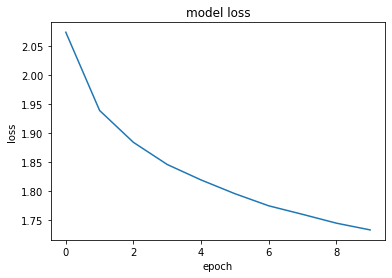

In [4]:
# 损失下降曲线
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# 测试
alex_net.evaluate(test_db)

plt.show()

In [5]:
# 加载数据集
(x_train_ori, y_train_ori), (x_test_ori, y_test_ori) = tf.keras.datasets.cifar10.load_data()

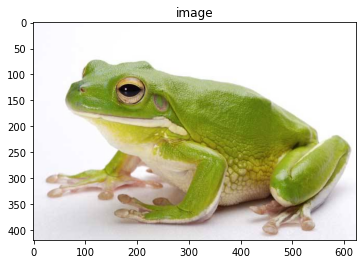

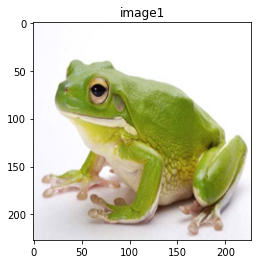

(1, 227, 227, 3)
(227, 227, 3)
[[6.9601171e-08 6.1291805e-10 4.0240134e-03 1.5658438e-04 4.8200047e-05
  3.7324028e-08 9.9574202e-01 4.6158213e-10 2.9021245e-05 3.8231942e-09]]
(1, 10)


array([6])

In [28]:
from PIL import Image
import os
img = Image.open(os.path.join('/home/lipenghui03/data/cifar10/','frog' + '.png'))
plt.figure("Image") # 图像窗口名称
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()
img = img.convert('RGB')
img = img.resize((227,227))
img_array = np.array(img)
# img_array = 255 - img_array
img_array = img_array.reshape((1,227,227,3))/255
plt.figure("Image1") # 图像窗口名称
plt.imshow(img_array[0])
plt.axis('on') # 关掉坐标轴为 off
plt.title('image1') # 图像题目
plt.show()
print(img_array.shape)
print(img_array[0].shape)
predict_test = alex_net.predict(img_array)
print(predict_test)
print(predict_test.shape)
np.argmax(predict_test,axis=1)  #axis = 1是取行的最大值的索引，0是列的最大值的索引

[4]


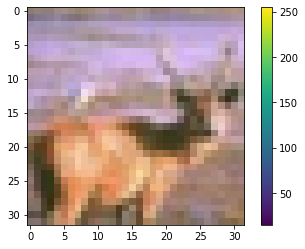

2.0934095498544254
-1.8816426241908337
255
0
9
0


In [19]:
index = 9000
plt.figure()
plt.imshow(x_train_ori[index])
print(y_train_ori[index])
plt.colorbar()
plt.grid(False)
plt.show()
print(x_test.max()) #获取整个矩阵的最大值 结果： 6
print(x_test.min()) #结果：1
print(x_train_ori.max()) #获取整个矩阵的最大值 结果： 6
print(x_train_ori.min()) #结果：1
print(y_train_ori.max()) #获取整个矩阵的最大值 结果： 6
print(y_train_ori.min()) #结果：1

### 0'airplane', 1'automobile', 2'bird', 3'cat', 4'deer', 5'dog', 6'frog', 7'horse', 8'ship', 9'truck'

In [17]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
outp_put_net = alex_net
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: outp_put_net(x))
full_model = full_model.get_concrete_function(
tf.TensorSpec(outp_put_net.inputs[0].shape, outp_put_net.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,logdir='/home/data/cifar10',name="frozen_graph_alex_net.pb",as_text=False)

--------------------------------------------------
Frozen model layers: 
x
sequential/conv2d/Conv2D/ReadVariableOp/resource
sequential/conv2d/Conv2D/ReadVariableOp
sequential/conv2d/Conv2D
sequential/conv2d/BiasAdd/ReadVariableOp/resource
sequential/conv2d/BiasAdd/ReadVariableOp
sequential/conv2d/BiasAdd
sequential/re_lu/Relu
sequential/max_pooling2d/MaxPool
sequential/batch_normalization/ReadVariableOp/resource
sequential/batch_normalization/ReadVariableOp
sequential/batch_normalization/ReadVariableOp_1/resource
sequential/batch_normalization/ReadVariableOp_1
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp/resource
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp_1/resource
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp_1
sequential/batch_normalization/FusedBatchNormV3
sequential/conv2d_1/Conv2D/ReadVariableOp/resource
sequential/conv2d_1/Conv2D/ReadVariableOp
sequential/conv2d_

'/home/lipenghui03/data/cifar10/frozen_graph_alex_net.pb'